# short corridor enviroment

http://www.incompleteideas.net/book/the-book.html 
Page 323

## enviroment

In [1]:
import numpy as np
import torch
import torch.nn.functional as F
from torch.distributions import Categorical

class GridWrold():
    def __init__(self):
        # enviroment setting
        self.num_grid = 4 
        self.action_dim = 2 # action= 0 or 1
        self.max_steps = 200
        
        # observation
        self.state = 0 # min_state=0, max_state=3
        self.terminated = False
        self.truncated = False
        self.episode_steps = 0
        
    def step(self, action:int):
        # action=0: left, action=1: right
        assert isinstance(action, int) 
        assert action >= 0 and action < self.action_dim
        
        # in state=1 in this enviroment, an agent moves to the other direction 
        if self.state == 1:
            direction = - (action*2-1) # map: action:[0, 1] -> direction [1, -1]
            self.move(direction)
        else:
            direction = action*2 - 1 # map: action:[0, 1] -> direction [-1, 1]
            self.move(direction)
                
        next_state = self.state
        reward = -1
        terminated = self.terminated = True if self.state >= self.num_grid - 1 else False
        truncated = self.truncated = self.episode_steps >= self.max_steps
        info = {}
        
        return next_state, reward, terminated, truncated, info
        
    def move(self, direction:int):
        # direction: -1 or 1
        if not self.terminated and not self.truncated:
            # move to next state
            self.state += direction
            
            # state should be between min_state and max_state
            if self.state < 0:
                self.state = 0
            if self.state >= self.num_grid:
                self.state = self.num_grid - 1
                
            # increase steps in the episode
            self.episode_steps += 1

    def reset(self):
        self.state = 0
        self.terminated = False
        self.truncated = False
        self.episode_steps = 0
        info = {}
        
        return self.state, info


## take random actions

In [2]:
#########################
# take random actions
#########################

env = GridWrold()
state, _ = env.reset()

NUM_TEST=500
total_rewards = np.zeros(NUM_TEST)
for j in range(NUM_TEST):
    total_reward = 0.0
    state, _ = env.reset()
    for i in range(1, 200):
        action = np.random.randint(2)
        next_state, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
        
        if terminated:
            break
        state = next_state
    total_rewards[j] = total_reward 
    
total_rewards.mean() # almost optimal

-11.976

## take actions following the optimal stochastic policy

In [3]:
############################################
# take actions following the optimal stochastic policy
############################################

probs = torch.tensor([np.sqrt(2) - 1, 2-np.sqrt(2)])
distribution = Categorical(probs)

env = GridWrold()
state, _ = env.reset()

NUM_TEST=500
total_rewards = np.zeros(NUM_TEST)
for j in range(NUM_TEST):
    total_reward = 0.0
    state, _ = env.reset()
    for i in range(1, 200):
        action = distribution.sample().item()
        next_state, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
        
        if terminated:
            break
        state = next_state
    total_rewards[j] = total_reward 
    
print(total_rewards.mean()) # about -11.6


-11.324


# plot objective function J(theta)

$$J(\theta) = -2 \frac{2-\theta}{\theta (1-\theta)} $$

where theta is the probability of slecting the right action(->)

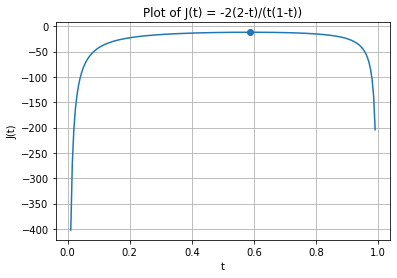

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# objective function
def J(t):
    return -2 * (2 - t) / (t * (1 - t))

# Generate x values in the desired range
t = np.linspace(0.01, 0.99, 200)  # Avoiding 0 and 1 to prevent division by zero

# Compute the corresponding y values using the function J(x)
y = J(t)

# Plot the function
plt.plot(t, y)
plt.scatter(2-np.sqrt(2), J(2-np.sqrt(2))) # optimal policy
plt.xlabel('t')
plt.ylabel('J(t)')
plt.title('Plot of J(t) = -2(2-t)/(t(1-t))')
plt.grid(True)
plt.show()
